<a href="https://colab.research.google.com/github/deepkick/FOSS4G_Kansai/blob/master/Data_preparationJP_20191014_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データ準備
## ソースデータセット
ISPRS Vaihingen Datasetは、ISPRSの委員会IIIによって提供されます。データセットは9 cmの空間解像度で構成されています
赤と緑のバンドが付いた航空写真。データセットには、約0.6 km2をカバーする16のラベル付きシーンが含まれます。
ラベルは6つのクラスに提供されます：不浸透性の表面、建物、低植生、木、車、クラッター/バックグラウンド。通常、ラベルの量が非常に限られているため、クラッター/バックグラウンドクラスは無視されます。
## データを確認する

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/FOSS4G_DeepLearning_HandsOn_datasets/')

In [3]:
import glob
print(glob.glob('./isprs_vaihingen/train/*/'))

['./isprs_vaihingen/train/label/', './isprs_vaihingen/train/label_rgb/', './isprs_vaihingen/train/image/']


In [4]:
print(glob.glob('./isprs_vaihingen/val/*/'))

['./isprs_vaihingen/val/label/', './isprs_vaihingen/val/image/', './isprs_vaihingen/val/label_rgb/']


In [5]:
print(glob.glob('./isprs_vaihingen/test/*/'))

['./isprs_vaihingen/test/label/', './isprs_vaihingen/test/image/', './isprs_vaihingen/test/label_rgb/']


### トレーニング画像とラベルを確認する

In [0]:
from PIL import Image
import numpy as np

PILを使用してイメージをndarrayとして読み取る

In [0]:
image = np.array(Image.open('./isprs_vaihingen/train/image/top_mosaic_09cm_area21.tif'))
label = np.array(Image.open('./isprs_vaihingen/train/label_rgb/top_mosaic_09cm_area21.tif'))

In [8]:
print(image.shape)
print(label.shape)

(2546, 1903, 3)
(2546, 1903, 3)


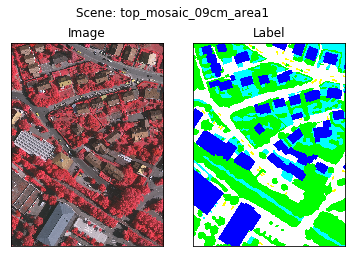

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Image')
fig.show()

ax = fig.add_subplot(122)
ax.imshow(label, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label')

fig.suptitle('Scene: top_mosaic_09cm_area1')
fig.show()



クラスラベルは次のとおりです。 <br>
0: 不浸透性の表面 (white)<br>
1: 建物 (blue)<br>
2: 低植生 (cyan)<br>
3: 樹木 (green)<br>
4: 車 (yellow)<br>

## 前処理
## 前処理
ディープラーニングメソッドを適用するには、次のように前処理を行う必要があります。
* 切り抜き
* 正規化

## 切り抜き
これで、トレーニング画像（area1）のサイズは $1919\times2569$ です。ご存知のように、リモートセンシング画像のサイズは非常に大きいことが一般的です。 1つの問題は、このような大きな画像にディープラーニングメソッドを直接適用できないことです。これは、メソッドが通常メモリを消費するためです。多くの場合、1つのモデルでサイズが $256\times256$のパッチを処理するために数GBのRAMメモリが必要です。ディープラーニングをリモートセンシング画像に適用するには、大きな画像から小さなパッチを切り抜く必要があります。ここでは、その方法を示します。

### 単一のパッチをランダムに切り取る
以下では、トレーニング画像とラベルから、サイズが $256\times256$ のトレーニングパッチをランダムに切り取ります。最初に、元の大きな画像からの単一パッチのトリミングを示します。

トレーニングイメージと対応するラベルのファイルパスを設定します。

In [0]:
fpath_train_image1 = './isprs_vaihingen/train/image/top_mosaic_09cm_area21.tif'
fpath_train_image2 = './isprs_vaihingen/train/image/top_mosaic_09cm_area7.tif'
fpath_train_label1 = './isprs_vaihingen/train/label/top_mosaic_09cm_area21.tif'
fpath_train_label2 = './isprs_vaihingen/train/label/top_mosaic_09cm_area7.tif'

インポートモジュール

In [0]:
import glob
import random
from PIL import Image
import numpy as np

トレーニング画像とラベルを読み込む

In [0]:
image1 = np.array(Image.open(fpath_train_image1))
image2 = np.array(Image.open(fpath_train_image2))
label1 = np.array(Image.open(fpath_train_label1))
label2 = np.array(Image.open(fpath_train_label2))

画像とラベルのペアをリストに配置

In [0]:
list_data = [
    ['top_mosaic_09cm_area21', image1, label1],
    ['top_mosaic_09cm_area7' , image2, label2],
]

トレーニングシーンのリストからターゲットシーンをランダムに選択する

In [0]:
name, image, label = random.choice(list_data)

トリミング位置をランダムに選択

In [0]:
height, width, _ = image.shape
patch_size = 256
ulx = random.randrange(0, width - patch_size + 1)
uly = random.randrange(0, height - patch_size + 1)

パッチペアをトリミングする

In [0]:
image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

ここで、サイズが $256\times256$ のパッチペアをトリミングしました。パッチを表示して、パッチが正しくトリミングされているかどうかを確認しましょう。

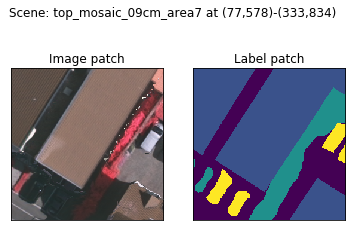

In [17]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image_patch, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
fig.show()
ax.set_title('Image patch')

ax = fig.add_subplot(122)
ax.imshow(label_patch, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label patch')

fig.suptitle('Scene: %s at (%d,%d)-(%d,%d)' % (name, ulx, uly, ulx+patch_size, uly+patch_size))
fig.show()


ニューラルネットワークは、入力として左側の画像パッチを受け取り、対応する分類結果を出力します。
トレーニングの目標は、ネットワークの出力が右側の真のラベルに近づくように、ネットワークパラメータを最適化することです。
目に見えない画像に一般化するネットワークをトレーニングするには、ネットワークがさまざまなパターンを学習できるように、さまざまなそのようなトレーニングパッチペアが必要です。そのため、以下では、トレーニングシーンから複数のパッチをトリミングします。

### 複数のパッチをランダムに切り取る
 上記のように、ここではトレーニングシーンから複数のパッチをトリミングします。基本的に、上記と同じ手順を繰り返し適用します。

トリミングの設定

In [0]:
num_patches = 750
patch_size = 256

トリミングされたパッチを含めるためのプレースホルダーを定義する

In [0]:
list_image_patches = []
list_label_patches = []

定義された数のパッチが収集されるまで、ランダムクロッピングを繰り返します。

In [0]:
for i in range(num_patches):
    # choose scenes randomly
    name, image, label = random.choice(list_data)

    # choose crop position randomly
    height, width, _ = image.shape
    ulx = random.randrange(0, width - patch_size + 1)
    uly = random.randrange(0, height - patch_size + 1)

    # crop
    image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
    label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

    # contain
    list_image_patches.append(image_patch)
    list_label_patches.append(label_patch)


プレースホルダーをndarrayに変換する

In [21]:
npy_image_patches = np.array(list_image_patches)
npy_label_patches = np.array(list_label_patches)

print(npy_image_patches.shape)
print(npy_label_patches.shape)

(750, 256, 256, 3)
(750, 256, 256)


トリミングされたパッチペアを確認する

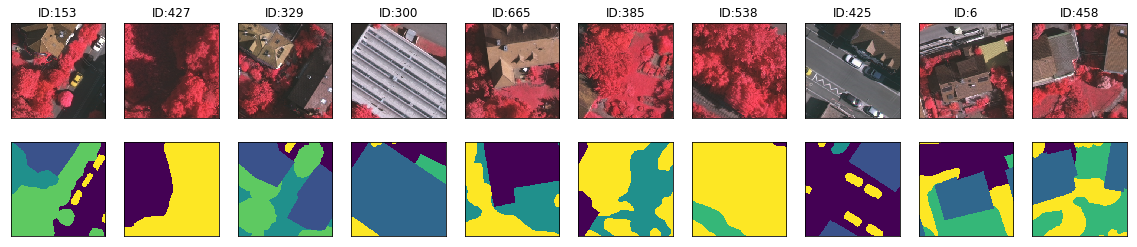

In [22]:
from matplotlib.gridspec import GridSpec
grid = GridSpec(nrows=2, ncols=10)

fig = plt.figure(figsize=(20,4))

for i in range(10):
    idx = random.randrange(len(npy_image_patches))
    image_patch = npy_image_patches[idx]
    label_patch = npy_label_patches[idx]
    
    ax = fig.add_subplot(grid[0,i])
    ax.imshow(image_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('ID:%d' % idx)

    ax = fig.add_subplot(grid[1,i])
    ax.imshow(label_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()


最後に、後で再利用できるように、トリミングコードを関数として実装します。<br><br>
**入力**: 
- シーンのリスト(name, image, label)
- 切り取るパッチの数
- パッチのサイズs

**出力**: 
- トリミングされた画像パッチ (ndarray)
- クロップドラベルパッチ (ndarray) 

In [0]:
def random_crop(list_data, num_patches, patch_size):
    list_image_patches = []
    list_label_patches = []

    for i in range(num_patches):
        # choose scenes randomly
        name, image, label = random.choice(list_data)

        # choose crop position randomly
        height, width, _ = image.shape
        ulx = random.randrange(0, width - patch_size + 1)
        uly = random.randrange(0, height - patch_size + 1)

        # crop
        image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
        label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

        # contain
        list_image_patches.append(image_patch)
        list_label_patches.append(label_patch)
    
    npy_image_patches =  np.array(list_image_patches)
    npy_label_patches =  np.array(list_label_patches)

    return npy_image_patches, npy_label_patches
    

## 正規化
必要な別の前処理は、トリミングされたパッチの正規化です。通常、ニューラルネットワークの入力画像は正規化されます。シンプルだが広く使用されている方法は、範囲調整です。メソッドは、ピクセル値の範囲を\[0,1\]または\[-1,1\]に調整します。たとえば、8ビットのイメージがある場合、各ピクセル値を255で除算すると、\[0,1\]の範囲のピクセル値になります。地上ベースの画像の場合、これらの方法は広く使用されています。ただし、リモートセンシング画像の場合、各バンドを正規化して平均と単位の分散をゼロにすることをお勧めします。

### なぜ正規化が必要なのでしょう？
主に2つの理由があります。
1. **高速なトレーニングと良好な収束のため。** ニューラルネットワークパラメーターの初期化は、正規化された入力を前提としています。したがって、正規化を行わないと、初期パラメーター値は最適とはほど遠いものになり、トレーニング時間が長くなるか、さらに悪いことにトレーニングが収束しなくなります。 
2. **堅牢性のため。** 取得条件（照明条件やセンサーなど）の影響を正規化するため。

以下では、正規化について説明します。

帯域ごとの平均と標準偏差を計算する

In [0]:
mean1 = np.mean(image1, axis=(0,1), keepdims=True)
mean2 = np.mean(image2, axis=(0,1), keepdims=True)
std1 = np.std(image1, axis=(0,1), keepdims=True)
std2 = np.std(image2, axis=(0,1), keepdims=True)

元の画像を正規化する

In [0]:
image1_normalized = (image1 - mean1) / std1
image2_normalized = (image2 - mean2) / std2

list_data_normalized = [
    ['top_mosaic_09cm_area21', image1_normalized, label1],
    ['top_mosaic_09cm_area7' , image2_normalized, label2],
]

正規化された画像を使用したランダムクロップ

In [0]:
npy_image_patches, npy_label_patches = random_crop(list_data_normalized, num_patches=750, patch_size=256)

これで、トレーニングデータの前処理が完了しました。最後に、トリミングしたパッチをnumpyファイルとして保存しましょう。

In [0]:
#  Set output directory for cropped patches
import os
output_dir_train = './isprs_vaihingen/train/patches/'
if not os.path.isdir(output_dir_train):
    os.mkdir(output_dir_train)

パッチをnumpyファイルとして保存

In [0]:
np.save(output_dir_train + '/image.npy', npy_image_patches)
np.save(output_dir_train + '/label.npy', npy_label_patches)

### 前処理検証パッチ
トレーニングパッチと同じ方法で検証パッチを前処理する

In [0]:
# set file path
fpath_val_image = './isprs_vaihingen/val/image/top_mosaic_09cm_area11.tif'
fpath_val_label = './isprs_vaihingen/val/label/top_mosaic_09cm_area11.tif'

# pre-load images and labels
image = np.array(Image.open(fpath_val_image))
label = np.array(Image.open(fpath_val_label))

# normalize
mean = np.mean(image1, axis=(0,1), keepdims=True)
std = np.std(image1, axis=(0,1), keepdims=True)
image_normalized = (image - mean) / std

# to list
list_data_normalized = [
    ['top_mosaic_09cm_area11', image_normalized, label],
]

# cropping
npy_image_patches, npy_label_patches = random_crop(list_data_normalized, num_patches=100, patch_size=256)

# save
output_dir_val = './isprs_vaihingen/val/patches/'
if not os.path.isdir(output_dir_val):
    os.mkdir(output_dir_val)
np.save(output_dir_val + '/image.npy', npy_image_patches)
np.save(output_dir_val + '/label.npy', npy_label_patches)

### 予測のためのテストパッチの前処理

テストパッチはランダムに作成されません。 

In [30]:
from PIL import Image
import numpy as np
import os

fpath_test_image = './isprs_vaihingen/test/image/top_mosaic_09cm_area30.tif'
fpath_test_label = './isprs_vaihingen/test/label/top_mosaic_09cm_area30.tif'
image = np.array(Image.open(fpath_test_image))
label = np.array(Image.open(fpath_test_label))

# Normalize
mean = np.mean(image, axis=(0,1), keepdims=True)
std = np.std(image, axis=(0,1), keepdims=True)
image = (image - mean) / std

patch_size = 256
stride = 256
height, width, _ = image.shape

num_tiles_x = (width - patch_size) // stride + 1
num_tiles_y = (height - patch_size) // stride + 1

list_image_patches = []
list_label_patches = []
for iy in range(num_tiles_y):
    for ix in range(num_tiles_x):
        ulx = ix * stride
        uly = iy * stride
        lrx = ulx + patch_size
        lry = uly + patch_size
            
        image_patch = image[uly:lry, ulx:lrx, :]
        label_patch = label[uly:lry, ulx:lrx]
        
        list_image_patches.append(image_patch)
        list_label_patches.append(label_patch)

npy_image_patches = np.array(list_image_patches)
npy_label_patches = np.array(list_label_patches)

# save
output_dir_test = './isprs_vaihingen/test/patches/'
if not os.path.isdir(output_dir_test):
    os.mkdir(output_dir_test)
np.save(output_dir_test + '/image.npy', npy_image_patches)
np.save(output_dir_test + '/label.npy', npy_label_patches)

print(npy_image_patches.shape)
print(npy_label_patches.shape)


(70, 256, 256, 3)
(70, 256, 256)
